In [1]:
import torch
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


In [2]:
# Load your dataset
df = pd.read_csv(r"C:\Users\sajal\Desktop\NLP Project_updated\T5_Coping_Tip_Dataset__Expanded_.csv").dropna()

# Split into train and validation
train_texts, val_texts = train_test_split(df, test_size=0.1, random_state=42)


C:\Users\sajal\AppData\Local\Temp\ipykernel_27156\2111904063.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.674000
200,0.129000
300,0.068800
400,0.047000
500,0.037800
600,0.033800



📊 Classification Report:
                                                                precision    recall  f1-score   support

                           a good day is still a step forward.       0.00      0.00      0.00         4
                                   answer one thing at a time.       0.00      0.00      0.00         2
                     ask someone to help you lighten the load.       0.00      0.00      0.00         3
            awareness is step one. now breathe and prioritize.       0.00      0.00      0.00         2
                        be curious, but treat yourself kindly.       0.00      0.00      0.00         3
                     being heard helps. call or text a friend.       0.00      0.00      0.00         3
                 cry if needed. expressing sadness is healing.       0.00      0.00      0.00         5
                       curiosity is good—balance it with rest.       0.00      0.00      0.00         5
         don’t hesitate to ask for re

c:\Users\sajal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

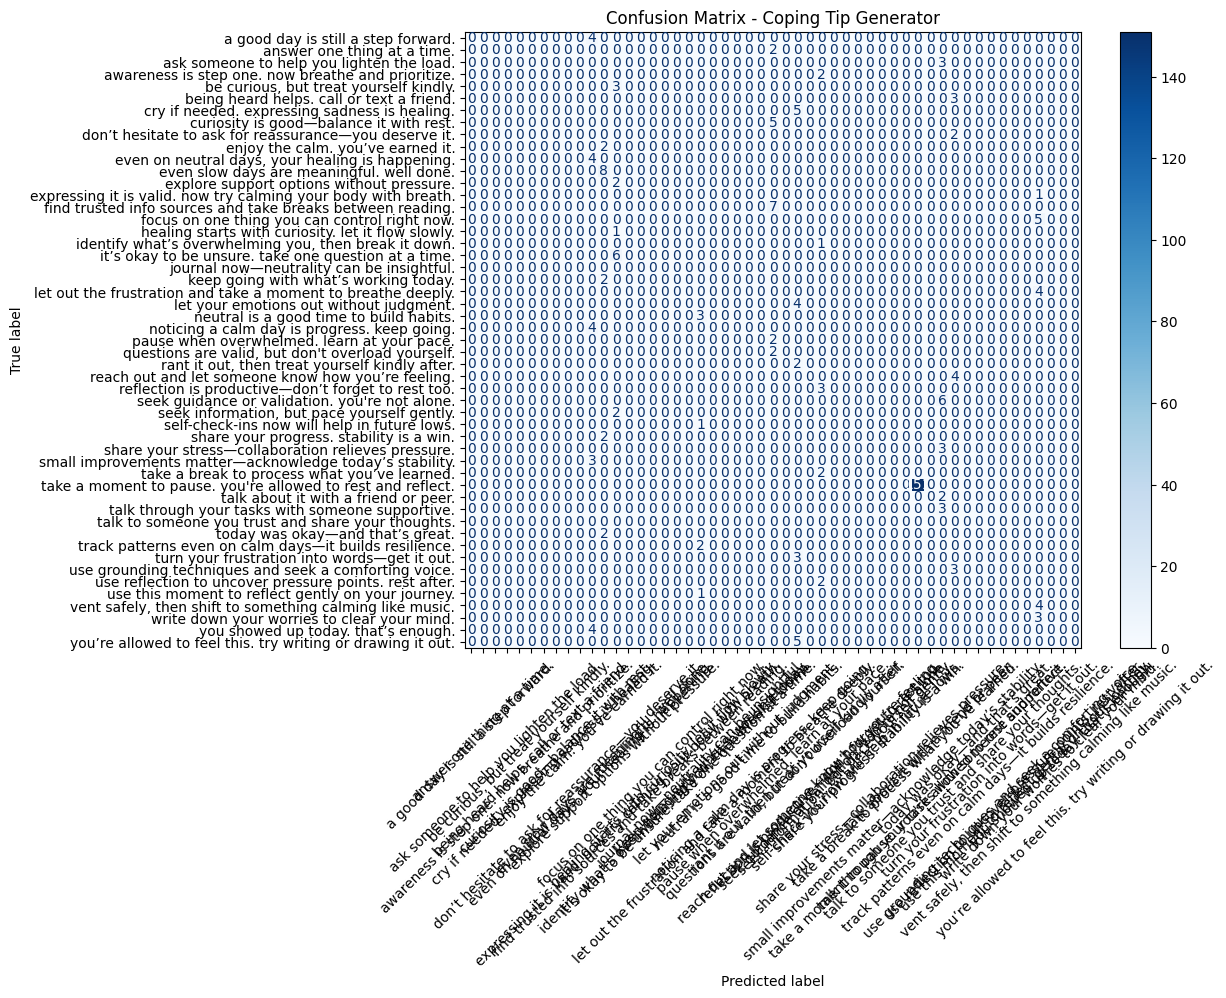

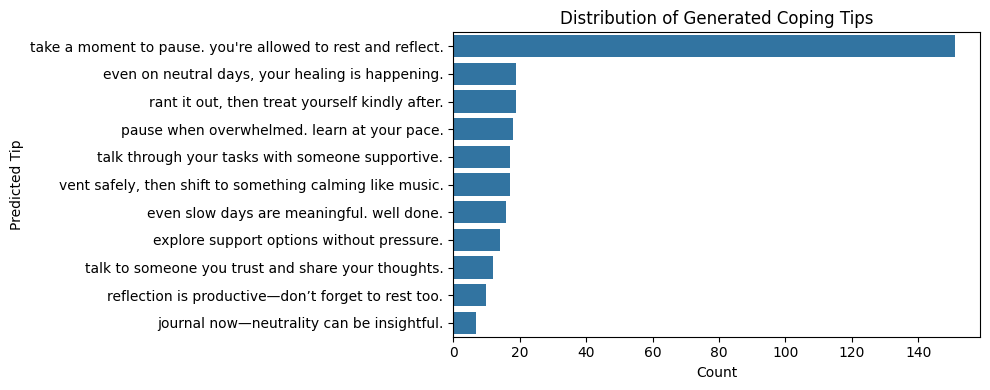

In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from torch.utils.data import Dataset
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# === Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# === Define Dataset Class
class CopingTipDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=64):
        self.inputs = df["input_text"].tolist()
        self.targets = df["target_text"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(
            self.inputs[idx], truncation=True, padding="max_length",
            max_length=self.max_length, return_tensors="pt"
        )
        target_enc = self.tokenizer(
            self.targets[idx], truncation=True, padding="max_length",
            max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }

# === Load data
df = pd.read_csv(r"C:\Users\sajal\Desktop\NLP Project_updated\T5_Coping_Tip_Dataset__Expanded_.csv").dropna()
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = CopingTipDataset(train_df, tokenizer)
val_dataset = CopingTipDataset(val_df, tokenizer)

# === Load model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# ✅ Compatible Training Args
training_args = TrainingArguments(
    output_dir="./t5_coping_model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    save_steps=500,
    logging_steps=100,
    learning_rate=3e-4,
    weight_decay=0.01,
    save_total_limit=1
)

# === Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

# === Evaluation with Visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

true_labels = []
pred_labels = []

for _, row in val_df.iterrows():
    input_text = row["input_text"]
    target_text = row["target_text"]

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=64
        )
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    true_labels.append(target_text.strip().lower())
    pred_labels.append(pred.strip().lower())

# === Metrics & Plots
print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels))

cm = confusion_matrix(true_labels, pred_labels, labels=sorted(set(true_labels + pred_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(true_labels + pred_labels)))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Coping Tip Generator")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(y=pred_labels, order=pd.Series(pred_labels).value_counts().index)
plt.title("Distribution of Generated Coping Tips")
plt.xlabel("Count")
plt.ylabel("Predicted Tip")
plt.tight_layout()
plt.show()


In [12]:
from rouge_score import rouge_scorer
import pandas as pd

# === Load your dataset with true & generated values ===
df = pd.read_csv(r"C:\Users\sajal\Desktop\NLP Project_updated\T5_Coping_Tip_Dataset__Expanded_.csv").dropna()
true_texts = df["target_text"].str.strip().tolist()
input_texts = df["input_text"].str.strip().tolist()

# === Load model and tokenizer ===
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

model_path = r"C:\Users\sajal\Desktop\NLP Project_updated\t5_coping_model"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === Generate predictions
generated_texts = []
for text in input_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=64, num_beams=4)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_texts.append(decoded.strip())

# === ROUGE Evaluation
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

for ref, pred in zip(true_texts, generated_texts):
    score = scorer.score(ref, pred)
    for key in scores:
        scores[key].append(score[key].fmeasure)

# === Print Averages
print("\n🔍 ROUGE Evaluation:")
for metric in scores:
    avg_score = sum(scores[metric]) / len(scores[metric])
    print(f"{metric.upper()} F1: {avg_score:.4f}")



🔍 ROUGE Evaluation:
ROUGE1 F1: 0.6434
ROUGE2 F1: 0.6117
ROUGEL F1: 0.6422
